# Cat/Dog Classifier

In this notebook I'll be training a model that will, given a picture of a cat or a dog, predict what's on the picture.

## Preparation

### Data Imports

The first step is importing the data.

For this task I'll be using a [kaggle-sourced Microsoft dataset](https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset).

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torchvision import datasets, transforms, models

from sklearn.metrics import f1_score, confusion_matrix

from PIL import Image

from tqdm.notebook import tqdm

from contextlib import nullcontext
from typing import Literal
import pickle

/home/metal_undivided/anaconda3/envs/practicum_souped/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Let's start by describing transforms applied to the loaded images.

I'll be resizing them to 224x224 since that is the size dictated by the model I'll be using.

I also will be skipping on augmentations (rotations, brightness, etc) for now - I may add them at a later point if need be and the time allows.

In [ ]:
transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

Next step would be creating a dataloader.

In [ ]:
BATCH_SIZE = 16
DATA_DIR = "/media/metal_undivided/Samsung_T5/Datasets/Cats_Dogs/PetImages/" ## change this if running this notebook on your machine

The dataset used here has a respectable number of images - approx. 12500 per class.

I will therefore be splitting it in the following manner:

Dataset | Fraction | Images per class
--------|----------|------------------
Training|    0.6   |    7500
Validation |    0.2   |  2500
Testing | 0.2   | 2500

Since there's a couple of zero-sized files in the dataset, I'll write a short function that will allow the dataloader to test whether the image is okay and omit it if it's not.

In [ ]:
def test_image(path):
    try:
        dummy = Image.open(path)
        return True
    except:
        return False

In [ ]:
dataset_root = datasets.ImageFolder(DATA_DIR, transform=transforms, is_valid_file=test_image)

dataset_train, dataset_val, dataset_test = torch.utils.data.random_split(dataset_root, [.6, .2, .2],
                                                                         ## to prevent data leakage
                                                                         generator=torch.Generator().manual_seed(111)
                                                                        )

loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

/home/metal_undivided/anaconda3/envs/practicum_souped/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Now that the dataloaders are initialized, we can have a good look at the data.

### Data Examination

I'll start by taking a look at the images.

In [ ]:
classes = dataset_root.find_classes(DATA_DIR)
classes = classes[1]
classes = {label:name for name, label in classes.items()}  ## Inverting the dict for use in inference

In [ ]:
pixels, labels = next(iter(loader_train))

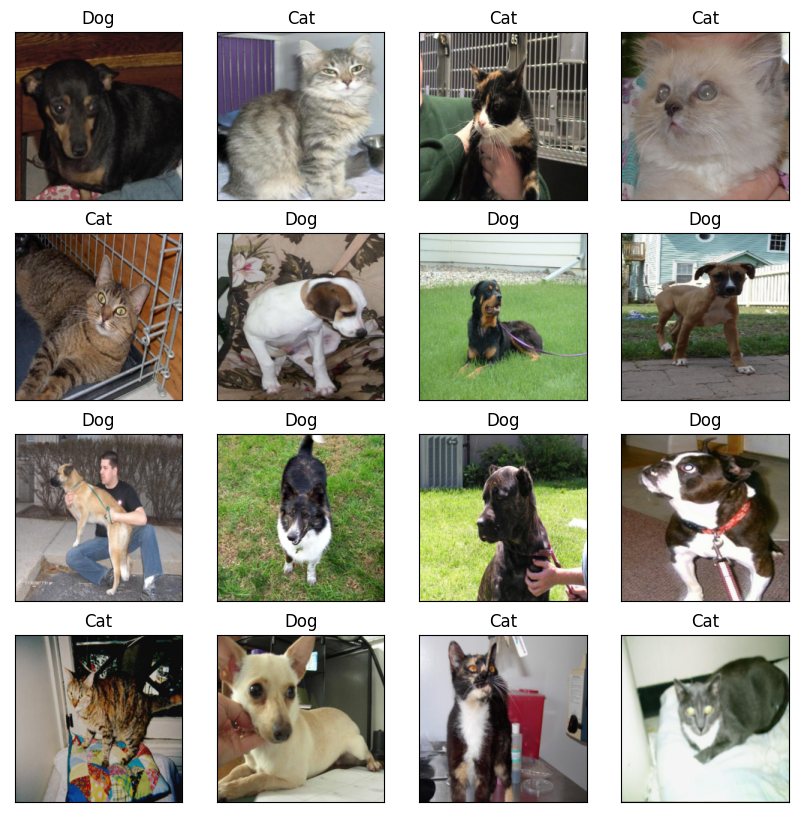

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i in range(16):
    axobject = axs[i // 4][i % 4]
    
    axobject.imshow(pixels[i].permute(1, 2, 0))
    axobject.set_title(classes[labels.numpy()[i]])
    axobject.get_xaxis().set_visible(False)
    axobject.get_yaxis().set_visible(False)

Everything appears to be working.

Observations so far:
* There is a wide variety of dog and cat breeds
* There is a fairly wide variety of poses and perspectives
* Lighting conditions appear to vary significantly
* There is some variation in portion of the image occupied by the subject

Overall, the dataset appears to be quite heterogeneous, which is to my advantage as it should allow the model to generalize better.

### Class Distribution

The dataset appeared to be perfectly balanced class-wise, but I will check this just in case.

In [ ]:
label_counts = torch.zeros(2)

for batch in iter(tqdm(loader_train, desc="Counting classes")):
    _, labels = batch
    
    label_counts += nn.functional.one_hot(labels, num_classes=2).sum(axis=0)
    
print(label_counts)

Counting classes:   0%|          | 0/938 [00:00<?, ?it/s]

tensor([7514., 7485.])


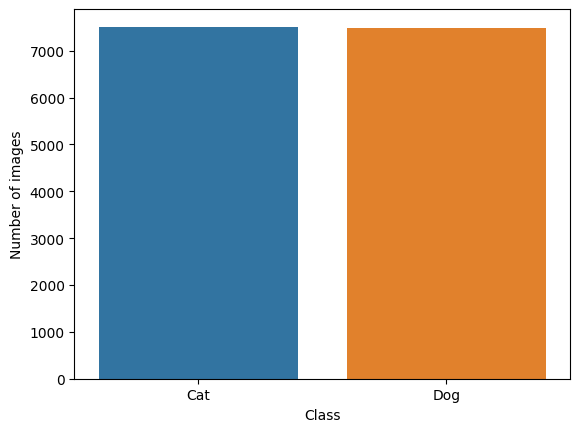

In [ ]:
fig, ax = plt.subplots()

sns.barplot(x=list(classes.values()), y=label_counts.numpy())

ax.set_xlabel("Class")
ax.set_ylabel("Number of images");

The classes are nearly perfectly balanced, as expected. The small difference is caused by sampling during the data splitting.

## Model Training

Now that the data is loaded and examined, I can get to training the model.

I am fairly constrained in computational capacity, all I have is a single Ryzen 4700 and no GPU. Therefore, for this task I will be training an [EfficientNet](https://arxiv.org/abs/1905.11946).

EfficientNet are a family of CNN known for being comparatively computationally light without much, if any, compromise in prediction quality. I will go with the lightest of them - the B0 variety as that should allow me to go over a number of training iterations and approaches quickly.

I will be using a pre-trained model provided by PyTorch as a custom implementation would be quite meaningless and time consuming.

The default weights provided by PyTorch are obtained by training on ImageNet 1K, a dataset of 1K classes with 1.2KK images total.

In [ ]:
model = models.efficientnet_b0(weights="DEFAULT")

I will try training it in two steps:
1. Training the last layer only with frozen convolutional layers
2. Fine-tuning all layers at a reduced learning rate.

Now that the model is initialized, I need to freeze the weights for convolutional layers and reinitialize the last linear layer since it was trained for an entirely different task and should be retrained in situ.

### Step 1 Training

In [ ]:
for param in model.parameters():
    param.requires_grad = False
    
n_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features=n_features, out_features=1)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,281 trainable parameters


Looks like the model should be ready for step 1.

Now I also need to implement a training loop and define loss function and optimizer.

I'll start with a training function for a batch.

In [ ]:
def fit_batch(model, features, target, optimizer, loss_fn):
    
    optimizer.zero_grad(set_to_none=True)
    
    predictions = model(features)
    
    loss = loss_fn(predictions.view(predictions.shape[0]), target)
    loss.backward()
    
    optimizer.step()
    
    return loss

Next I'll define the optimizer and loss function.

For loss function I'll be using binary cross-entropy, whereas for the optimizer I'll be using Adam.

I'll also implement a learning rate decay, havling it in half every 3 epochs.

In [ ]:
learning_rate = 5e-4
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=3, gamma=.5, verbose=True)

loss_fn = nn.BCEWithLogitsLoss()

Adjusting learning rate of group 0 to 5.0000e-04.


The final piece is the training loop itself.

Since the task that I'm solving here is a binary classfication task, I'll be using F1 score as the main metric for evaluating model performance.

In [ ]:
def epoch_loop(loader, model, optimizer, loss_fn, loop_type:Literal["training", "validation"], epoch_num) -> tuple:
    
    with torch.no_grad() if loop_type=="validation" else nullcontext():

        epoch_loss = 0
        epoch_preds = []
        epoch_truths = []

        for counter, batch in enumerate(tqdm(loader, desc=loop_type.title())):

            pixels, labels = batch

            epoch_truths += labels

            if loop_type == "training":
                epoch_loss += fit_batch(model, pixels, labels.float(), optimizer, loss_fn).item()

            elif loop_type == "validation":
                epoch_loss += loss_fn(model(pixels).view(labels.shape[0]), labels.float()).item()

            with torch.no_grad():
                proba = nn.Sigmoid()(model(pixels)).view(labels.shape[0])
                epoch_preds += list(torch.where(proba < .5, 0, 1))

        loss = epoch_loss / (counter + 1)
        score = f1_score(epoch_truths, epoch_preds)

        print(f"Epoch {epoch_num + 1} {loop_type} loss: {loss:.4f}")
        print(f"Epoch {epoch_num + 1} {loop_type} score: {score:.4f}")
        
        metrics = loss, score
        labels = epoch_truths, epoch_preds

        return metrics, labels, model

```python
EPOCHS = 15
best_score = 0
best_params = None

losses_train = []
scores_train = []
losses_valid = []
scores_valid = []

model.train(True)

for epoch in range(EPOCHS):
    
    ## Training
    
    metrics, labels, model_buffer = epoch_loop(loader_train, model, optimizer, loss_fn, loop_type="training", epoch_num=epoch)
    loss, score = metrics
    
    losses_train.append(loss)
    scores_train.append(score)
    
    
    ## Validation
    
    metrics, labels, model_buffer = epoch_loop(loader_val, model, optimizer, loss_fn, loop_type="validation", epoch_num=epoch)
    loss, score = metrics
    
    losses_valid.append(loss)
    scores_valid.append(score)
    
    
    ## Saving the best model parameters
    
    if score > best_score:
        best_score = score
        best_params = model_buffer.state_dict()
    
    ## End of epoch, lr decay
    scheduler.step()

model.load_state_dict(best_params)
model.eval();
```

Now that the model is trained I will first save it for later use, then we can plot the training results. 

```python
torch.save(model, "EfficientNetB0_cats_dogs_ft_st1.torch")
```

```python
train_results = {
    "best_score":best_score,
    "losses_train":losses_train,
    "scores_train":scores_train,
    "losses_valid":losses_valid,
    "scores_valid":scores_valid
}

with open("train_results_st1", "wb") as results_file:
    pickle.dump(train_results, results_file)
```

In [ ]:
model = torch.load("EfficientNetB0_cats_dogs_ft_st1.torch")

In [ ]:
with open("train_results_st1", "rb") as results_file:
    train_results = pickle.load(results_file)
    
best_score = train_results["best_score"]

### Step 1 Results

Let's plot the training results so far.

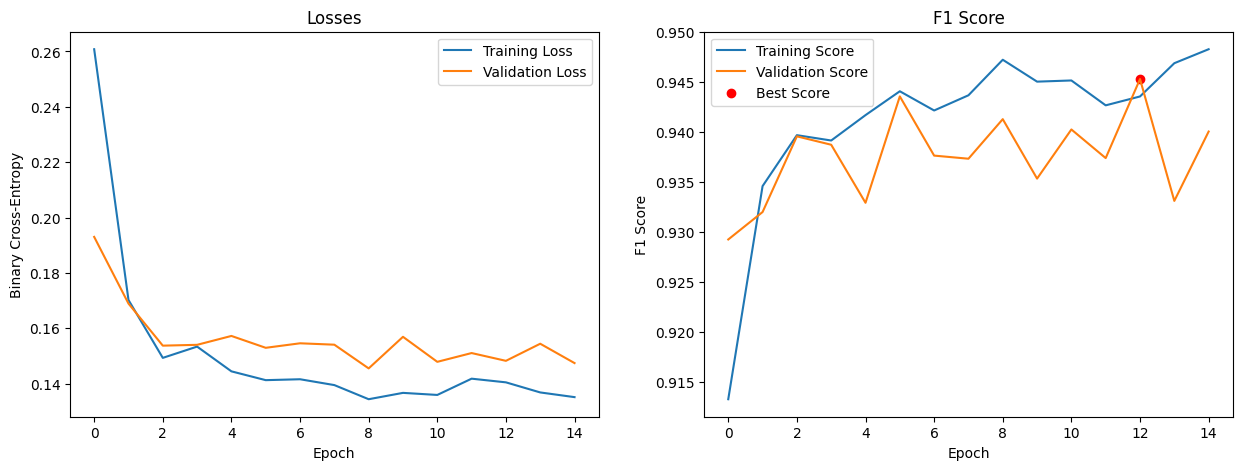

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(range(len(train_results["losses_train"])), train_results["losses_train"], label="Training Loss")
axs[0].plot(range(len(train_results["losses_valid"])), train_results["losses_valid"], label="Validation Loss")
axs[0].set_title("Losses")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Binary Cross-Entropy")
axs[0].legend()

axs[1].plot(range(len(train_results["scores_train"])), train_results["scores_train"], label="Training Score")
axs[1].plot(range(len(train_results["scores_valid"])), train_results["scores_valid"], label="Validation Score")
axs[1].set_title("F1 Score")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("F1 Score")

axs[1].scatter(train_results["scores_valid"].index(train_results["best_score"]), train_results["best_score"], label="Best Score", color="red")

axs[1].legend();

Looks like the loss function flattens out starting at around 5th epoch. It is therefore unreasonable to expect improvements in score with further training.

The score itself is quite respectable at ~0.95, so it may make sense to leave it as it is.

Still, let's see if a better result can be obtained by training the model further with unfrozen convolutional layers.

### Step 2 Training

I'll start by unfreezing the layers and redefining optimizer.

In [ ]:
for param in model.parameters():
    param.requires_grad = True
    
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,008,829 trainable parameters


Since fine tuning typically requires a smaller learning rate, I'll reduce the starting value compared to the previous loop.

In [ ]:
learning_rate = 3e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=3, gamma=.5, verbose=True)

loss_fn = nn.BCEWithLogitsLoss()

Adjusting learning rate of group 0 to 3.0000e-05.


Everything appears to be ready, let's traing the model then.

```python
EPOCHS = 6

losses_train = []
scores_train = []
losses_valid = []
scores_valid = []

model.train(True)

for epoch in range(EPOCHS):
    
    ## Training
    
    metrics, labels, model_buffer = epoch_loop(loader_train, model, optimizer, loss_fn, loop_type="training", epoch_num=epoch)
    loss, score = metrics
    
    losses_train.append(loss)
    scores_train.append(score)
    
    
    ## Validation
    
    metrics, labels, model_buffer = epoch_loop(loader_val, model, optimizer, loss_fn, loop_type="validation", epoch_num=epoch)
    loss, score = metrics
    
    losses_valid.append(loss)
    scores_valid.append(score)
    
    
    ## Saving the best model parameters
    
    if score > best_score:
        best_score = score
        best_params = model_buffer.state_dict()
    
    ## End of epoch, lr decay
    scheduler.step()

model.load_state_dict(best_params)
model.eval();
```

Looks like an increase in score.

We'll have a look at training results once I save the model.

```python
torch.save(model, "EfficientNetB0_cats_dogs_ft_st2.torch")
```

```python
train_results = {
    "best_score":best_score,
    "losses_train":losses_train,
    "scores_train":scores_train,
    "losses_valid":losses_valid,
    "scores_valid":scores_valid
}

with open("train_results_st2", "wb") as results_file:
    pickle.dump(train_results, results_file)
```

In [ ]:
model = torch.load("EfficientNetB0_cats_dogs_ft_st2.torch")

In [ ]:
with open("train_results_st2", "rb") as results_file:
    train_results = pickle.load(results_file)
    
best_score = train_results["best_score"]

### Step 2 Results

Let's have a look at the results.

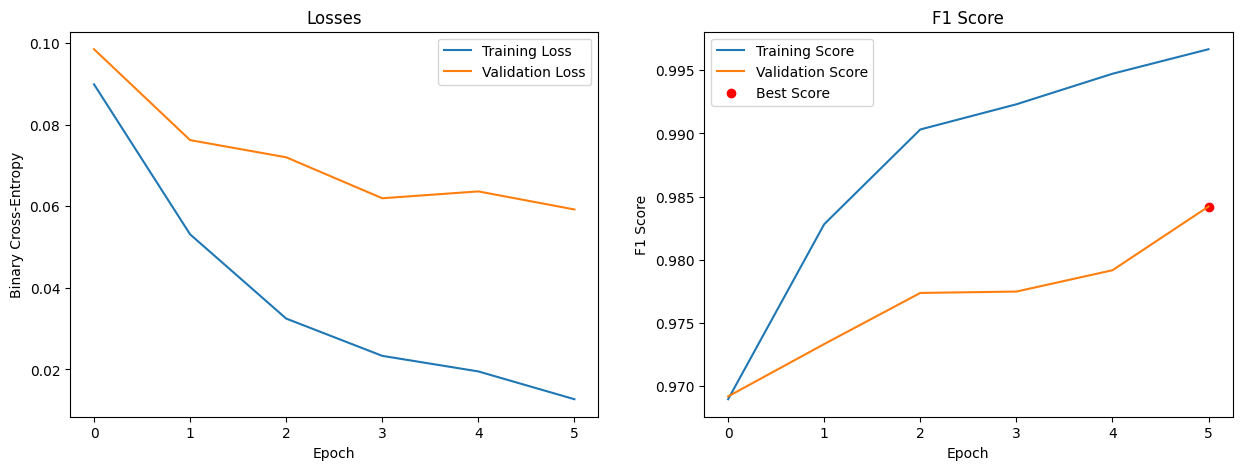

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(range(len(train_results["losses_train"])), train_results["losses_train"], label="Training Loss")
axs[0].plot(range(len(train_results["losses_valid"])), train_results["losses_valid"], label="Validation Loss")
axs[0].set_title("Losses")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Binary Cross-Entropy")
axs[0].legend()

axs[1].plot(range(len(train_results["scores_train"])), train_results["scores_train"], label="Training Score")
axs[1].plot(range(len(train_results["scores_valid"])), train_results["scores_valid"], label="Validation Score")
axs[1].set_title("F1 Score")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("F1 Score")

axs[1].scatter(train_results["scores_valid"].index(train_results["best_score"]), train_results["best_score"], label="Best Score", color="red")

axs[1].legend();

Looks like the model is done training: the loss function is approaching zero and the F1 score for training dataset is approaching unity.

It may be possible to get some marginal gains in score with a few more epochs as the loss curve hasn't flattened out fully, but I won't be testing this hypothesis at the time.

All that's left is to test the model and inspect it.

## Model Testing

I'll give the model the testing dataset and see what score it gets.

In [ ]:
metrics, labels, model = epoch_loop(loader_test, model, optimizer, loss_fn, loop_type="validation", epoch_num=0)

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

/home/metal_undivided/anaconda3/envs/practicum_souped/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1 validation loss: 0.0317
Epoch 1 validation score: 0.9891


Looks good to me!

Now let's pick a batch of images and visualize them alongside their predictions.

In [ ]:
truths_test, preds_test = labels

## Model Examination

In [ ]:
pixels, labels = next(iter(loader_test))

with torch.no_grad():
    proba = nn.Sigmoid()(model(pixels))
    preds = torch.where(proba < .5, 0, 1)
    proba = torch.where(preds == 1, proba, 1 - proba)

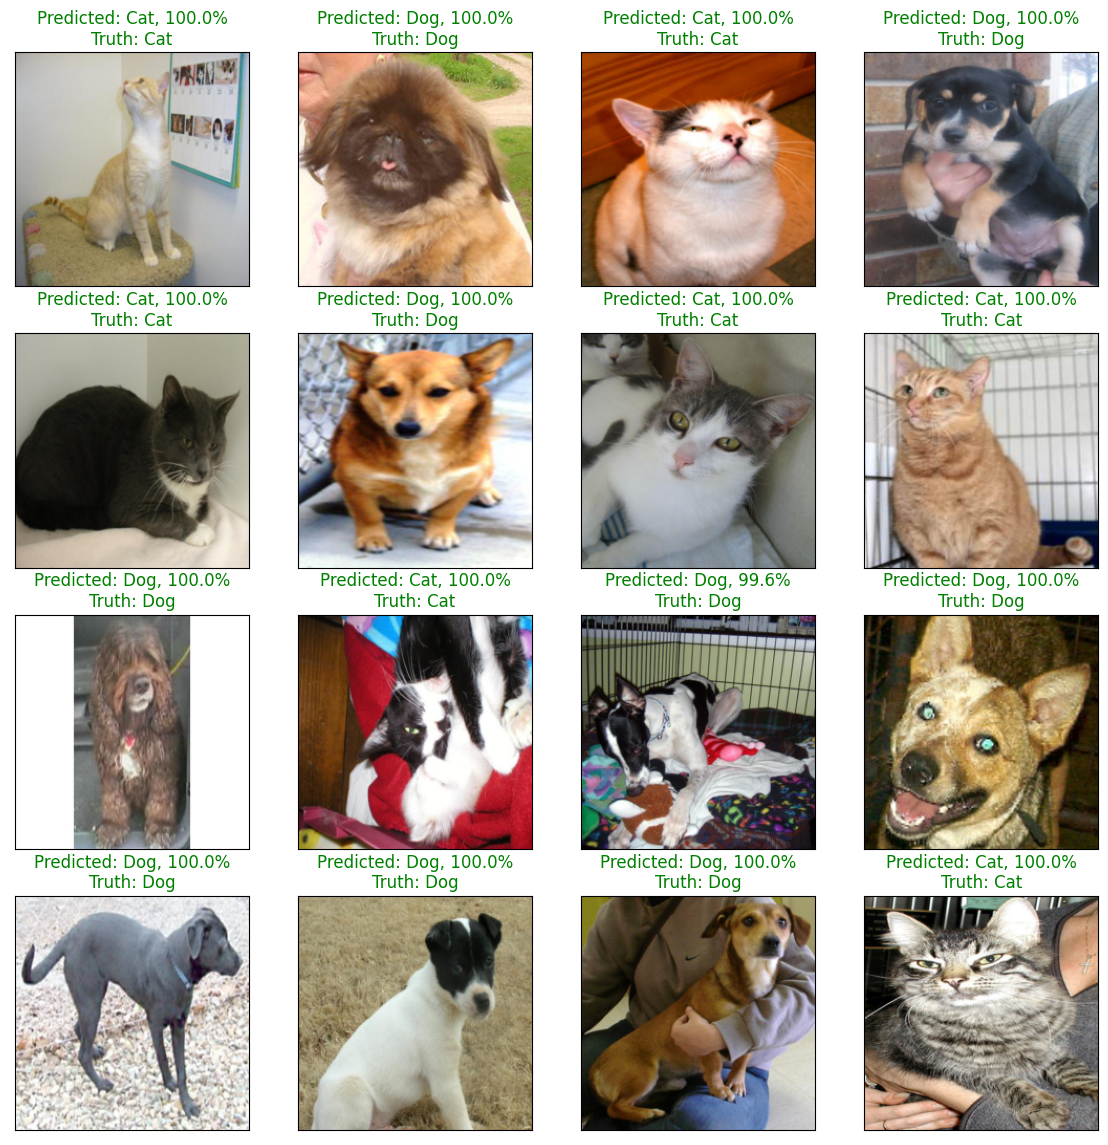

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(14, 14))

for i in range(16):
    
    predicted = classes[int(preds.numpy()[i])]
    truth = classes[int(labels.numpy()[i])]
    probability = float(proba.numpy()[i])
    
    axobject = axs[i // 4][i % 4]
    
    axobject.imshow(pixels[i].permute(1, 2, 0))
    
    axobject.set_title(f"Predicted: {predicted}, {probability:.1%}\nTruth: {truth}", 
                       color="green" if predicted == truth else "red"
                      )
    
    axobject.get_xaxis().set_visible(False)
    axobject.get_yaxis().set_visible(False)

The labels and probabilities seem to be in line with what was expected given the high F1 score on the test dataset.

Now let's build a confusion matrix.

In [ ]:
matrix = confusion_matrix(truths_test, preds_test)

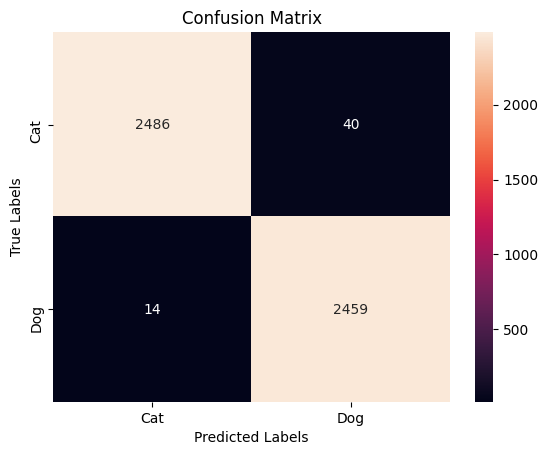

In [ ]:
ax = plt.subplot()

sns.heatmap(matrix, annot=True, fmt="g", ax=ax)

ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.xaxis.set_ticklabels(["Cat", "Dog"])
ax.yaxis.set_ticklabels(["Cat", "Dog"]);

The results are again in line with what was expected from the F1 values.

Looks like the model is performing well: the scores between the validation and training datasets are high and similar, **the model can be recommended for further use**.

## Conclusions

* A model was trained in order to identify whether a cat or a dog was depicted in a photo.
* A [Microsoft Research-provided dataset](https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset) of 25000 images (12500 per class) was used for training, validaton and testing.
* The dataset was split into a training, validation and testing subsets in 60%/20%/20% proportions respectively.
* No augmentations were applied to the trainig set (save for resizing), therefore there is a potential for accuracy gains if augmentations are used.
* F1 score was selected as the main metric.
* EfficientNetB0 was choosen as the architecture for the model.
* The model was fine-tuned in two steps with ImageNet 1K weights being used a starting point:
    1. Classifier tuning with convolutional layers frozen, 15 epochs
    2. Further fine-tuning with convolutional layers unfrozen, 6 epochs
* The model showed F1 score of ~0.985 on validation subset during the final fine-tuning.
* The model was then tested on the testing subset where it exhibited an F1 score of 0.989. The confusion matrix for testing is represented below:
![confusion_matrix](./confusion_matrix.png)

* The model clearly exhibits high predictive capabilities and can therefore be **recommeneded for further use**.
* The model was saved in the same directory as this notebook with the name **EfficientNetB0_cats_dogs_ft_st2.torch**